# 第5章 因果推論と機械学習の融合

## 5.1 機械学習を用いた因果推論の全体像

機械学習を用いた因果推論でできること

1. 因果効果の推定とその予測精度の評価
   * メタラーナー(Meta-learner): 複数の基本的な予測モデルを組み合わせて因果効果を推測するメタラーナーの種類
     * S-leaner
     * T-learner
     * X-leaner
     * DR-leaner
   * 既存の機械学習手法を、CATEを直接推定するために変更したもの(アンサンブル学習、ノンパラメトリックな手法)
     * Causal Forest
     * Causal BART
2. 複数の選択肢の中で期待効用が最大のものを予測: [5.7節](#54-doubledebiased-machine-leaningdml)で説明

## 5.2 因果推論に機械学習を使用する際の注意点

### 5.2.1 識別仮定に関する注意点

特に機会学習では多くの変数を用いるので、識別仮定を満たすかの判断が難しい

1. 交絡因子により因果関係を誤る可能性
   例えば航空会社が休日に需要が多くなるので値上げをした場合、価格が高くなれば売上げが上がるという逆の推論が出来上がる可能性がある
   因果推論のフレームワークを適切に使用すること

2. 処置変数が独立でない可能性
   処置変数が潜在的結果変数と条件付き独立であるという仮定が、未観測の交絡因子により崩れる可能性がある。ただし、処置変数に影響するが、結果変数に影響を与えない1つ以上の操作変数を識別できる場合は、条件付き独立の仮定は不要。
   例えば、航空会社のチケット代に関して、燃料費は変動が航空券の需要(結果変数)と独立しているが、売上げには航空券の価格(処置変数)を通じて影響するので、操作変数とみなせる
   ![図5.4](images/chap5/image.png)
   事前実験を使用して対応できる場合がある

### 5.2.2 推定に関する注意点

3. 学習時と予測時のデータの性質が異なる(分布シフトの発生の)可能性
   機械学習は学習データとテストデータが同一の分布から独立にサンプリングされる(independent and identically distributed: i.i.d.)という仮定のもと使用される
   過去データを用いたオフライン評価と、現実環境におけるオンライン評価で、コンバージョンレート(CVR)が向上しないなど
   COVID-19パンデミック下で顧客の行動が変化し、Amazonの予測アルゴリズムが機能不全になった

   このような分布シフトに対応する手法も提案されているが、最終的にはA/Bテストが有効
4. 過適合、正則化バイアス
   [5.4節](#57-因果的意思決定)で説明
5. データの質が悪く、CATE推定の信頼性が低い
   機械学習は大量のデータをを必要とするので、データの質が重要。また、同じモデルでもCATEを推定する対象(属性)によって精度が変わる可能性がある

### 5.2.3 結果及びモデルの解釈・公平性に関する注意点

6. モデルが複雑になり解釈が難しい
   現状複雑なモデルは説明不能だが、SHAPなどで対応できる場合がある。今後の研究に期待

7. 不当な差別を助長した予測をする可能性
   データセット内にすでに特定の属性(例えば人種、性別、宗教など)にバイアスが存在する場合、モデルもそれを反映する可能性がある。
   モデルの設計の段階で公平性を担保するように考慮する必要がある。

## 5.3 メタラーナー

CATEの高精度化のための手法。Uberが2021年時に使用を発表した。

CATEの条件が共変量$X=x$として設定されていると仮定する。

このとき、
1. 条件付き独立: $\{ Y(1), Y(0) \} \perp T|X=x$
2. 条件付き正値性: $( 0 < P(T=1|X=x) < 1)$
3. SUTVA

これらを仮定したうえで、CATEは結果変数の条件付き期待値の差分$\tau(x)$となる
$$
\begin{align}
&\mu_1(x) = E[Y(1) | X=x] \nonumber\\
&\mu_0(x) = E[Y(0) | X=x] \nonumber\\
&\tau(x) = \mu_1(x) - \mu_0(x) = E[Y(1) - Y(0)|X = x] \nonumber
\end{align}
$$

しかし、$Y(1)|X=x$のデータを取得すると$Y(0)|X=x$が取得できない、もしくはその逆。となるため、この取得できないデータを機械学習を用いて推定する。

### 5.3.1 S-leaner、T-leaner、X-leaner

1. S-leaner: 処置群と対照群を1つのモデルで推定する方法
   全データに対して、XとTからYを予測するモデルを用いる
   $$
   \hat{\tau_S}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)
   $$
2. T-leaner: 処置群と対照群をそれぞれ別のモデルで推定する方法
   処置群と対照群の各データを使用した2つのモデルを用いて推測する
   $$
   \hat{\tau_T}(x) = \hat{\mu_1}(x) - \hat{\mu_0}(x)
   $$

#### S-leanerとT-leanerの課題
* S-leaner
    * 処置効果にバイアスが発生する傾向がある(特に処置変数Tの結果変数Yへの影響が、共変量Xの影響に比べて小さい場合、ゼロに向かってバイアスがかかる)
    * 正則化された機械学習モデルを用いるので、この正則化により、推定される処置効果が制限される可能性がある
      [次節のDouble/debiased machine leaning](#54-doubledebiased-machine-leaningdml)で対応
* T-leaning
    * データを処置群と対照群に分けて機械学習する際に、正則化バイアスが発生する可能性がある(特に処置群のサンプルサイズが小さく、対照群のサンプルサイズが大きい場合)。つまり、不必要に単純な構造になるなどの弊害が出る

3. X-leaner
   上記のような問題への対応策の一つ。処置あり/なしのそれぞれの場合の効果を推定したうえで、以下の2点を行い精度を高めていく
   * 結果変数の正解データと、推定した因果効果の差分も活用
   * 傾向スコアでの重み付け

X-leanerの実行手順は以下となる
#### Step 1 T-leanerの構築
T-leanerを用いて$\hat{\mu_1}(x)$と$\hat{\mu_0}(x)$を推定

#### Step 2 反実仮想の推定と2通りのCATEの推定・調整
処置群と対照群のITE(個体の因果効果)を推定: $\hat{\mu_1}(x)$と$\hat{\mu_0}(x)$と結果ヘンス$Y_i(1)$と$Y_i(0)$の差$\widetilde{D_i^1}$, $\widetilde{D_i^2}$を算出

$$
処置群: \widetilde{D_i^1} = Y_i(1) - \hat{\mu_1}(X_i^1) \\
対象群: \widetilde{D_i^0} = \hat{\mu_0}(X_i^0) - Y_i(0)
$$
* $\hat{\mu_1}(X_i^1)$と$\hat{\mu_0}(X_i^0)$は共変量($X_i^1$, $X_i^0$)を用いた潜在結果変数であり、推測値
* $Y_i(1)$、$Y_i(0)$は実測値

理想的には上式の右辺は処置群・対照群ともに0(実測値と推定値は同じ)となるべき

$X = x$のとき、因果効果\tau(x)は
$\tau_1(x) = E[\widetilde{D^1} | X=x]$
$\tau_0(x) = E[\widetilde{D^0} | X=x]$

として、
$\tau(x) = \tau_1(x) = \tau_0(x)$
つまり、処置群でも対照群でも因果効果は同じとなる。この理想に近づけるため$\hat{\tau_1}(x)$、$\hat{\tau_0}(x)$をモデルから推定する

ただしこのままではT-leaningの課題であったように処置群のサンプルサイズが小さい場合に$\hat{\tau_0}(x)$の推定精度が低い可能性があるので、CATE$\hat{\tau_1}(x)$、$\hat{\tau_0}(x)$に対して、重み付けを行い、最終的に$\hat{\tau}(x)$を得る
$$
\hat{\tau}(x_i) = \hat{\pi}(x_i)\hat{\tau_0} + (1 - \hat{\pi}(x_i))\hat{\tau_1}(x_i)
$$

* $\hat{\pi}(x)$: 重み関数(=傾向スコア)。勾配ブースティングなどを用いる

#### S-leaner、 T-leaner、X-leanerのまとめ 
「社会的圧力を利用してアメリカの選挙での投票率を上げられるかを探求した大規模な投票動員(Get-Out-the-Vote)の実験」(Gerber, Green, and Larimer 2008)

![図5.10](images/chap5/image-1.png)

「戸別訪問により、マイアミでのトランスフォビア(トランスジェンダーの人への否定的な態度や不寛容)を持続的に減少させることができるかどうかを探求した実験」のデータ(Broockman
Kalla 2016)

![図5.11](images/chap5/image-2.png)

いすれも、X-leanerのほうが良好な結果を示されている

### 5.3.2 Doubly Robust Leaner

* DR-leaner: T-leanerを理論上改善した手法

T-leanerをベースに、処置群モデルと対照群モデルそれぞれの推定値の残差に逆確率重み付け(IPW)を追加したもの

結果変数モデルと傾向スコアモデルを組み合わせることで、傾向スコアが小さい場合にIPWモデルの推定値が大きくばらつくなどの欠点に対応。第3章の二重にロバストな推定法の考え方と同じ。

実行手順
1. データセットを2つに分割($D_1, D_2$)
2. $D_1$を用いて結果変数モデルと傾向スコアモデルを構築
3. 結果変数モデル($\hat{\mu}_1(X_i), \hat{\mu}_0(X_i)$)と傾向スコアモデル($\hat{\pi}(X_i)$)から以下の式の推定量$\phi$を計算
   $$
   \phi = \hat{\mu}_1 (X_i)
      + \frac{T_i (Y_i - \hat{\mu}_1 (X_i))}
         {\hat{\pi}(X_i)}
      - \left(
            \hat{\mu}_0(X_i)
            + \frac{(1-T_i) (Y_i - \hat{\mu}_0 (X_i))}
            {1 - \hat{\pi}(X_i)}
      \right) \\
   
   \hat{\tau}_{DR} = E\left[ \phi | X=x \right]
   $$
4. 最後に$\phi$と$D_2$を用いて$\hat{\tau}_{DR}$を推定

上式では分母に傾向スコアモデル推定値($\hat{\pi}(X_i)$)があるため、極端な$\hat{\pi}(X_i)$だと、大きな$\hat{\tau}_{DR}$につながる可能性があるため、傾向スコア分布を確認と調整が必要なケースがある

### 5.3.2 メタラーナーの実行手順
問題設定: 売上に対するキャンペーンの効果検証(CATEの推定: 顧客の収入別のキャンペーン効果)をメタラーナーの4種類のモデルで行い、どのモデルが最も精度が高いか、また、推定したCATEはどの程度かを確認する。

#### Step 1 ライブラリとデータの準備
econmlを使用する


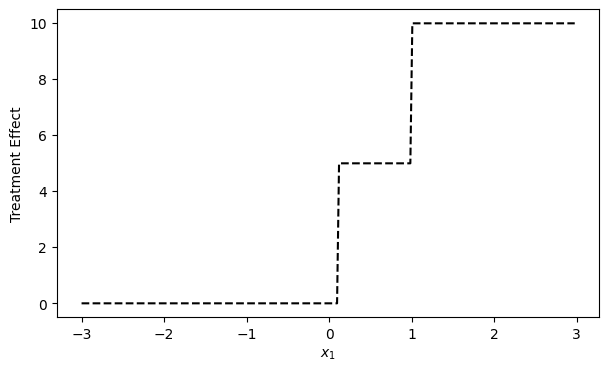

In [6]:
from typing import Any

import matplotlib.pyplot as plt
import numpy as np

"""使用データの生成"""


def generate_data(
    n: int,
    d: int,
    controls_outcome: callable,
    treatment_effect: callable,
    propensity: callable,
) -> tuple[Any, np.ndarray[Any], np.ndarray[Any, np.dtype[np.float64]]]:
    """使用するデータを生成."""
    rng = np.random.default_rng(1)
    # 共変量を生成
    X = rng.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # 処置変数を生成
    # 各共変量に対して、propensity関数を用いて傾向スコアを計算
    # この確率を基に二項分布から処置変数を生成
    T = np.apply_along_axis(lambda x: rng.binomial(1, propensity(x), 1)[0], 1, X)
    # 結果変数の生成
    # Y0
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    # Y1
    treatment_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treatment_effect * T
    return (Y, T, X)


"""各関数
controls_outcome
treatment_effect
propensity
の定義"""


class GenerateControlsOutcome:
    """与えられた共変量xに対してその共変量と係数betaのドット積を計算し、正規分布ノイズを加えて結果を返す."""

    def __init__(self, d: int) -> None:
        self.rng = np.random.default_rng(1)
        # 各共変量の影響を表す係数を生成
        self.beta = self.rng.uniform(-2, 2, d)

    # 与えられた共変量xに対してその共変量と係数betaのドット積を計算し、
    # 正規分布ノイズを加えて結果を返す
    def __call__(self, x: np.ndarray) -> float:
        """与えられた共変量xに対してその共変量と係数betaのドット積を計算し、正規分布ノイズを加えて結果を返す."""
        return np.dot(x, self.beta) + self.rng.normal(0, 1)


def treatment_effect(x: np.ndarray) -> float:
    """処置効果を返す."""
    threathold_max = 1
    threathold_min = 0.1
    return 10 if x[1] > threathold_max else (5 if x[1] > threathold_min else 0)


def propensity(x: np.ndarray) -> float:
    """傾向スコアを返す."""
    threathold_max = 0.5
    threathold_min = -0.5
    # x[2]が-0.5から0.5の間の場合、確率0.7を返す
    # それ以外の場合、確率0.3を返す
    return 0.7 if (x[2] > threathold_min and x[2] < threathold_max) else 0.3


d = 10  # 共変量を10個に設定
n = 1000  # 学習データのサンプルサイズ
control_outcome = GenerateControlsOutcome(d)

Y, T, X = generate_data(n, d, control_outcome, treatment_effect, propensity)

"""実際の処置効果を確認"""
rng = np.random.default_rng(1)
# テストデータのサンプルサイズ
n_test = 250
# テストデータの共変量を生成
X_test = rng.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
# グラフ描画用の設定
plot_range_s = -3
plot_range_e = 3
pitch = (plot_range_e - plot_range_s) / n_test
X_test[:, 1] = np.arange(plot_range_s, plot_range_e, pitch)
true_effects = np.array([treatment_effect(x) for x in X_test])
plt.figure(figsize=(7, 4))
plt.plot(
    X_test[:, 1],
    np.apply_along_axis(treatment_effect, 1, X_test),
    color="black",
    ls="--",
    label="Baseline",
)
plt.xlabel("$x_1$")
plt.ylabel("Treatment Effect")
plt.show()


#### Step 2
#### Step 3
#### Step 4
#### Step 5



## 5.4 Double/debiased machine leaning(DML)

## 5.7 因果的意思決定

#


In [7]:
from econml.dr import DRLearner
from econml.metalearners import SLearner, TLearner, XLearner
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# ベースモデルの設定
GBR = GradientBoostingRegressor()  # 勾配ブースティングによる回帰クラスの設定
GBC = GradientBoostingClassifier()  # 勾配ブースティングによる分類クラスの設定

# モデルの初期化
models = {
    "S-Learner": SLearner(overall_model=GBR),
    "T-Learner": TLearner(models=(GBR, GBR)),
    "X-Learner": XLearner(models=(GBR, GBR)),
    "DR-Learner": DRLearner(model_regression=GBR, model_propensity=GBC),
}

# モデルの学習と評価
np.random.seed(1)  # 乱数のシードを設定
results = {}
for name, model in models.items():
    model.fit(Y, T, X=X)
    preds = model.effect(X_test)  # テストデータを用いてCATEを推定
    mse = mean_squared_error(true_effects, preds)  # MSEを計算
    results[name] = mse
results

{'S-Learner': 1.683292733630935,
 'T-Learner': 2.471624662541262,
 'X-Learner': 0.7130158557383657,
 'DR-Learner': 7.61147207282376}

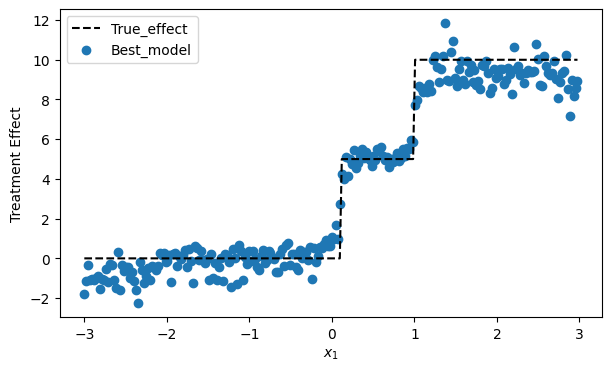

In [8]:
# 最も精度の高いモデルを選択
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

# CATEの推定結果の可視化
plt.figure(figsize=(7, 4))
plt.plot(
    X_test[:, 1],
    np.apply_along_axis(treatment_effect, 1, X_test),
    color="black",
    ls="--",
    label="True_effect",
)
plt.scatter(X_test[:, 1], best_model.effect(X_test), label="Best_model")
plt.xlabel("$x_1$")
plt.ylabel("Treatment Effect")
plt.legend()
plt.show()